In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"
OUT_DIR = r"D:\tracking\BackendTestes\plots_telemetry_5horas"  # pasta de saída
MAX_POINTS = 200_000  # downsample para acelerar (ajuste conforme necessário)

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# tenta identificar coluna de tempo
time_col = None
for c in df.columns:
    cl = c.lower()
    if cl in ("time", "timestamp", "datetime", "ts") or "time" in cl or "timestamp" in cl:
        time_col = c
        break

if time_col is None:
    raise ValueError("Não encontrei uma coluna de tempo. Renomeie a coluna de tempo para conter 'time' ou 'timestamp'.")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

# mantém só colunas numéricas
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
if not num_cols:
    raise ValueError("Não encontrei colunas numéricas para plotar.")

# =========================
# DOWNSAMPLE (opcional)
# =========================
n = len(df)
if n > MAX_POINTS:
    idx = np.linspace(0, n - 1, MAX_POINTS).astype(int)
    df_plot = df.iloc[idx].copy()
else:
    df_plot = df

# =========================
# PLOT & SAVE
# =========================
os.makedirs(OUT_DIR, exist_ok=True)

for col in num_cols:
    fig = plt.figure()
    plt.plot(df_plot[time_col], df_plot[col])
    plt.xlabel("Tempo")
    plt.ylabel(col)
    plt.title(col)
    plt.tight_layout()

    safe_name = "".join(ch if ch.isalnum() or ch in ("-", "_", ".") else "_" for ch in col)
    out_path = os.path.join(OUT_DIR, f"{safe_name}.png")
    fig.savefig(out_path, dpi=150)
    plt.close(fig)

print(f"OK: {len(num_cols)} gráficos salvos em: {OUT_DIR}")


OK: 67 gráficos salvos em: D:\tracking\BackendTestes\plots_telemetry_5horas


Variáveis usadas na correlação: 39


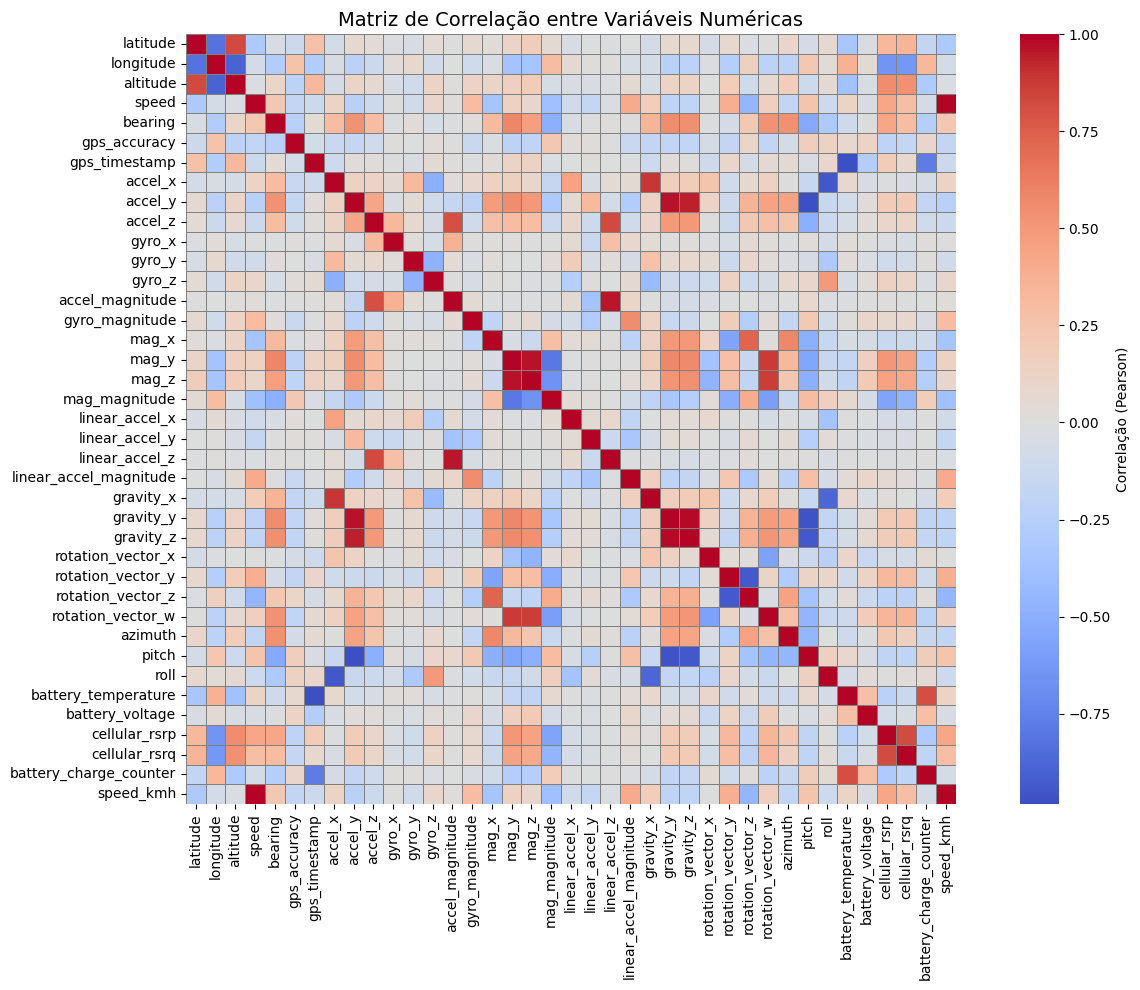

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# =========================
# SELEÇÃO DE COLUNAS NUMÉRICAS
# =========================
df_num = df.select_dtypes(include=[np.number]).copy()

# =========================
# LIMPEZA
# =========================

# remove colunas totalmente nulas
df_num = df_num.dropna(axis=1, how="all")

# remove colunas constantes (apenas um valor único)
df_num = df_num.loc[:, df_num.nunique(dropna=True) > 1]

# remove linhas com qualquer NaN restante
df_num = df_num.dropna(axis=0, how="any")

if df_num.shape[1] < 2:
    raise ValueError("Não há variáveis suficientes após a limpeza para calcular correlação.")

print(f"Variáveis usadas na correlação: {df_num.shape[1]}")

# =========================
# MATRIZ DE CORRELAÇÃO
# =========================
corr = df_num.corr(method="pearson")

# =========================
# PLOT SEABORN
# =========================
plt.figure(figsize=(14, 10))

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"label": "Correlação (Pearson)"}
)

plt.title("Matriz de Correlação entre Variáveis Numéricas", fontsize=14)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"
TOP_N = 30  # quantas correlações mais fortes mostrar

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# =========================
# NUMÉRICAS
# =========================
df_num = df.select_dtypes(include=[np.number]).copy()

# remove colunas totalmente nulas
df_num = df_num.dropna(axis=1, how="all")

# remove colunas constantes
df_num = df_num.loc[:, df_num.nunique(dropna=True) > 1]

# remove linhas com NaN
df_num = df_num.dropna(axis=0, how="any")

if df_num.shape[1] < 2:
    raise ValueError("Variáveis insuficientes após limpeza.")

# =========================
# CORRELAÇÃO
# =========================
corr = df_num.corr(method="pearson")

# =========================
# TRANSFORMA EM RANKING
# =========================
corr_long = (
    corr
    .where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # remove duplicados e diagonal
    .stack()
    .reset_index()
)

corr_long.columns = ["Variável_1", "Variável_2", "Correlação"]
corr_long["|Correlação|"] = corr_long["Correlação"].abs()

ranking = corr_long.sort_values("|Correlação|", ascending=False)

# =========================
# RESULTADO
# =========================
print(f"\nTop {TOP_N} correlações mais fortes:\n")
print(ranking.head(TOP_N).to_string(index=False))



Top 30 correlações mais fortes:

         Variável_1             Variável_2  Correlação  |Correlação|
              speed              speed_kmh    1.000000      1.000000
      gps_timestamp    battery_temperature   -0.982915      0.982915
            accel_y                  pitch   -0.982351      0.982351
          gravity_y              gravity_z    0.979295      0.979295
              mag_y                  mag_z    0.964749      0.964749
          gravity_y                  pitch   -0.961635      0.961635
            accel_y              gravity_y    0.961507      0.961507
    accel_magnitude         linear_accel_z    0.953776      0.953776
            accel_x                   roll   -0.947783      0.947783
          gravity_z                  pitch   -0.941002      0.941002
            accel_y              gravity_z    0.940698      0.940698
  rotation_vector_y      rotation_vector_z   -0.935577      0.935577
          longitude               altitude   -0.890583      0.890583


In [4]:
import numpy as np

# nomes esperados das colunas (ajuste se necessário)
LAT_COL = "latitude"
LON_COL = "longitude"

# evita divisão por zero e valores inválidos
df["lat_lon"] = np.where(
    (df[LON_COL] != 0) & (~df[LON_COL].isna()) & (~df[LAT_COL].isna()),
    df[LAT_COL] / df[LON_COL],
    np.nan
)


In [5]:
df


,time,device_id,operator_id,latitude,longitude,altitude,speed,bearing,gps_accuracy,satellites,...,motion_flat_down,motion_stowed,motion_display_rotate,transmission_mode,speed_kmh,topic,received_at,raw_payload,message_id,lat_lon
0,2025-12-12 17:19:26.139000-03:00,TRK-101,101,-11.698294,-47.161600,366.900024,5.44,151.0,3.79,NaN,...,NaN,NaN,NaN,online,19.584,aura/tracking/TRK-101/telemetry,2025-12-12 20:19:25.108621+00:00,"{'gps': {'alt': 366.9000244140625, 'lat': -11....",61f2270a-0d5e-4936-a939-d79cadcbe625,0.248047
1,2025-12-12 17:19:27.139000-03:00,TRK-101,101,-11.698333,-47.161572,366.900024,5.71,141.0,3.79,NaN,...,NaN,NaN,NaN,online,20.556,aura/tracking/TRK-101/telemetry,2025-12-12 20:19:26.113823+00:00,"{'gps': {'alt': 366.9000244140625, 'lat': -11....",a37b101e-90b3-41be-b0d8-3b96d37209d8,0.248048
2,2025-12-12 17:19:28.140000-03:00,TRK-101,101,-11.698376,-47.161535,366.900024,6.03,140.0,3.79,NaN,...,NaN,NaN,NaN,online,21.708,aura/tracking/TRK-101/telemetry,2025-12-12 20:19:27.123811+00:00,"{'gps': {'alt': 366.9000244140625, 'lat': -11....",a317e142-1be6-4d4b-8a58-a5b31a9d9d9b,0.248049
3,2025-12-12 17:19:29.139000-03:00,TRK-101,101,-11.698411,-47.161497,366.900024,5.75,133.0,3.79,NaN,...,NaN,NaN,NaN,online,20.700,aura/tracking/TRK-101/telemetry,2025-12-12 20:19:28.109351+00:00,"{'gps': {'alt': 366.9000244140625, 'lat': -11....",d03fcbfd-dde4-445f-89c7-a0a392ac4295,0.248050
4,2025-12-12 17:19:30.139000-03:00,TRK-101,101,-11.698445,-47.161464,366.900024,5.45,135.0,3.79,NaN,...,NaN,NaN,NaN,online,19.620,aura/tracking/TRK-101/telemetry,2025-12-12 20:19:29.110237+00:00,"{'gps': {'alt': 366.9000244140625, 'lat': -11....",3410d98a-3c6f-4db0-b09f-3463886f075c,0.248051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,2025-12-12 18:19:22.141000-03:00,TRK-101,101,-11.695745,-47.164231,367.000000,4.02,134.0,3.79,NaN,...,NaN,NaN,NaN,online,14.472,aura/tracking/TRK-101/telemetry,2025-12-12 21:19:21.154753+00:00,"{'gps': {'alt': 367.0, 'lat': -11.6957452, 'lo...",16bc868e-8899-4f17-b570-4d1e22934b42,0.247979
3597,2025-12-12 18:19:23.140000-03:00,TRK-101,101,-11.695773,-47.164206,367.000000,4.06,137.0,3.79,NaN,...,NaN,NaN,NaN,online,14.616,aura/tracking/TRK-101/telemetry,2025-12-12 21:19:22.120600+00:00,"{'gps': {'alt': 367.0, 'lat': -11.6957735, 'lo...",bc04ffd6-ea3c-477d-b213-300434024040,0.247980
3598,2025-12-12 18:19:24.138000-03:00,TRK-101,101,-11.695802,-47.164182,367.000000,4.10,138.0,3.79,NaN,...,NaN,NaN,NaN,online,14.760,aura/tracking/TRK-101/telemetry,2025-12-12 21:19:23.115365+00:00,"{'gps': {'alt': 367.0, 'lat': -11.6958024, 'lo...",ab43a702-0892-4e09-9cdf-6a44fd6509ee,0.247981
3599,2025-12-12 18:19:25.138000-03:00,TRK-101,101,-11.695832,-47.164158,367.000000,4.24,139.0,3.79,NaN,...,NaN,NaN,NaN,online,15.264,aura/tracking/TRK-101/telemetry,2025-12-12 21:19:24.119264+00:00,"{'gps': {'alt': 367.0, 'lat': -11.6958319, 'lo...",f0ddfee9-d1b4-4577-8f25-bba5037a98b3,0.247981


Variáveis usadas:
['speed_kmh', 'altitude', 'latitude', 'longitude', 'linear_accel_magnitude', 'pitch', 'roll', 'lat_lon']


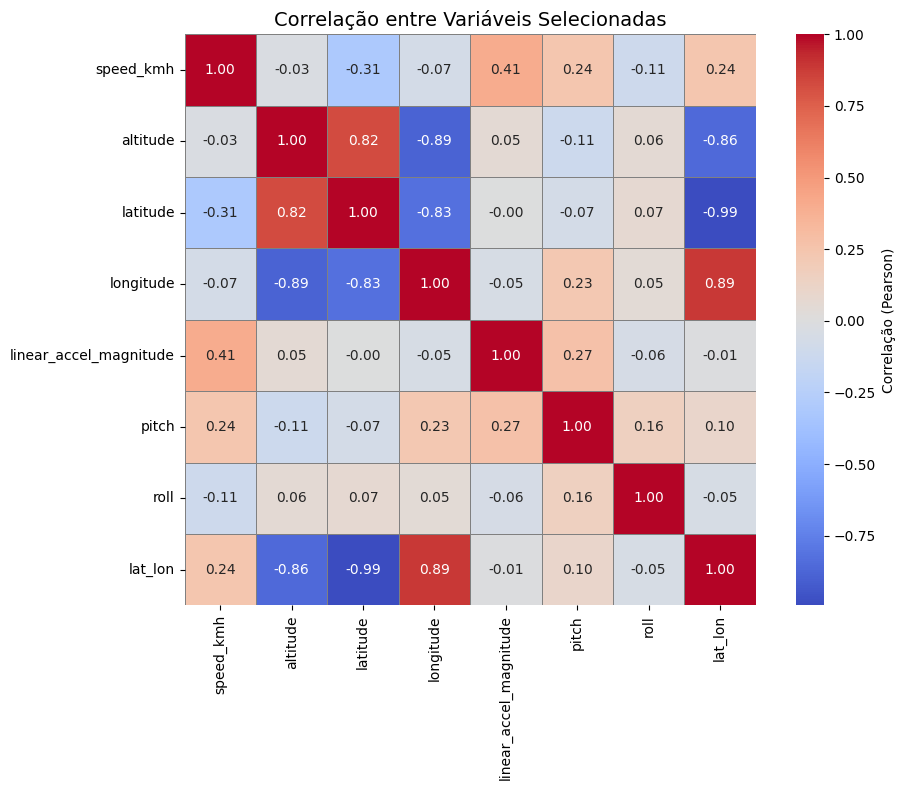

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

COLS = [
    "speed_kmh",
    "altitude",
    "latitude",
    "longitude",
    "linear_accel_magnitude",
    "pitch",
    "roll"
]

LAT_COL = "latitude"
LON_COL = "longitude"

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# =========================
# FEATURE: lat / lon
# =========================
df["lat_lon"] = np.where(
    (df[LON_COL] != 0) & (~df[LON_COL].isna()) & (~df[LAT_COL].isna()),
    df[LAT_COL] / df[LON_COL],
    np.nan
)

COLS.append("lat_lon")

# =========================
# SELEÇÃO E LIMPEZA
# =========================
df_sel = df[COLS].copy()

# remove colunas totalmente nulas
df_sel = df_sel.dropna(axis=1, how="all")

# remove colunas constantes
df_sel = df_sel.loc[:, df_sel.nunique(dropna=True) > 1]

# remove linhas com NaN
df_sel = df_sel.dropna(axis=0, how="any")

if df_sel.shape[1] < 2:
    raise ValueError("Variáveis insuficientes para correlação após limpeza.")

print("Variáveis usadas:")
print(df_sel.columns.tolist())

# =========================
# CORRELAÇÃO
# =========================
corr = df_sel.corr(method="pearson")

# =========================
# PLOT
# =========================
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"label": "Correlação (Pearson)"}
)

plt.title("Correlação entre Variáveis Selecionadas", fontsize=14)
plt.tight_layout()
plt.show()


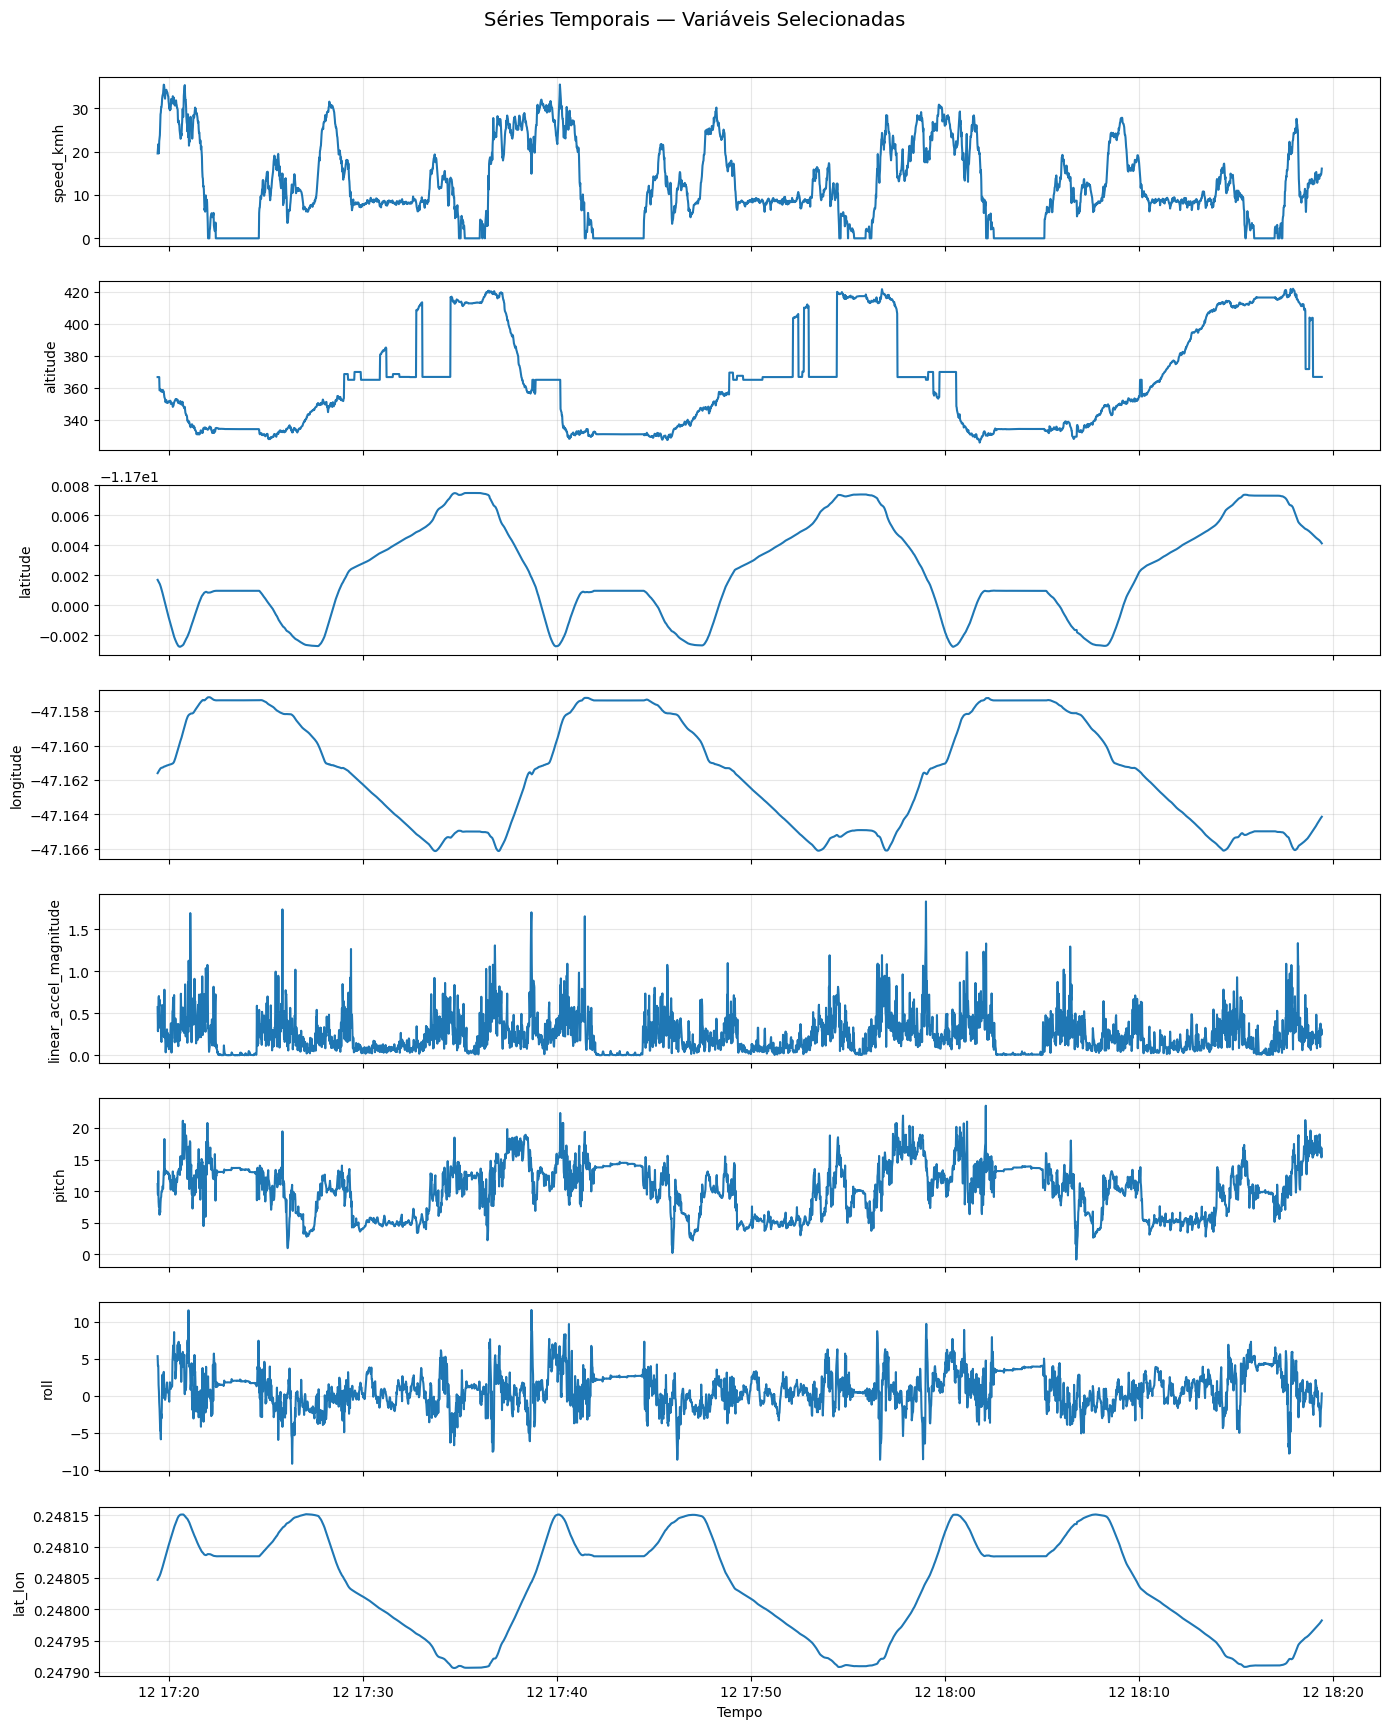

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

TIME_COL_CANDIDATES = ["time", "timestamp", "datetime", "ts"]

COLS = [
    "speed_kmh",
    "altitude",
    "latitude",
    "longitude",
    "linear_accel_magnitude",
    "pitch",
    "roll"
]

LAT_COL = "latitude"
LON_COL = "longitude"

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# =========================
# IDENTIFICA COLUNA DE TEMPO
# =========================
time_col = None
for c in df.columns:
    cl = c.lower()
    if cl in TIME_COL_CANDIDATES or "time" in cl or "timestamp" in cl:
        time_col = c
        break

if time_col is None:
    raise ValueError("Coluna de tempo não encontrada.")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

# =========================
# FEATURE: lat / lon
# =========================
df["lat_lon"] = np.where(
    (df[LON_COL] != 0) & (~df[LON_COL].isna()) & (~df[LAT_COL].isna()),
    df[LAT_COL] / df[LON_COL],
    np.nan
)

COLS.append("lat_lon")

# =========================
# SELEÇÃO E LIMPEZA
# =========================
df_sel = df[[time_col] + COLS].copy()

# remove colunas totalmente nulas
df_sel = df_sel.dropna(axis=1, how="all")

# remove colunas constantes
df_sel = df_sel.loc[:, df_sel.nunique(dropna=True) > 1]

# remove linhas com NaN
df_sel = df_sel.dropna(axis=0, how="any")

vars_plot = [c for c in df_sel.columns if c != time_col]

# =========================
# PLOT
# =========================
n = len(vars_plot)
fig, axes = plt.subplots(
    nrows=n,
    ncols=1,
    figsize=(14, 2.2 * n),
    sharex=True
)

if n == 1:
    axes = [axes]

for ax, col in zip(axes, vars_plot):
    ax.plot(df_sel[time_col], df_sel[col])
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Tempo")

plt.suptitle("Séries Temporais — Variáveis Selecionadas", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


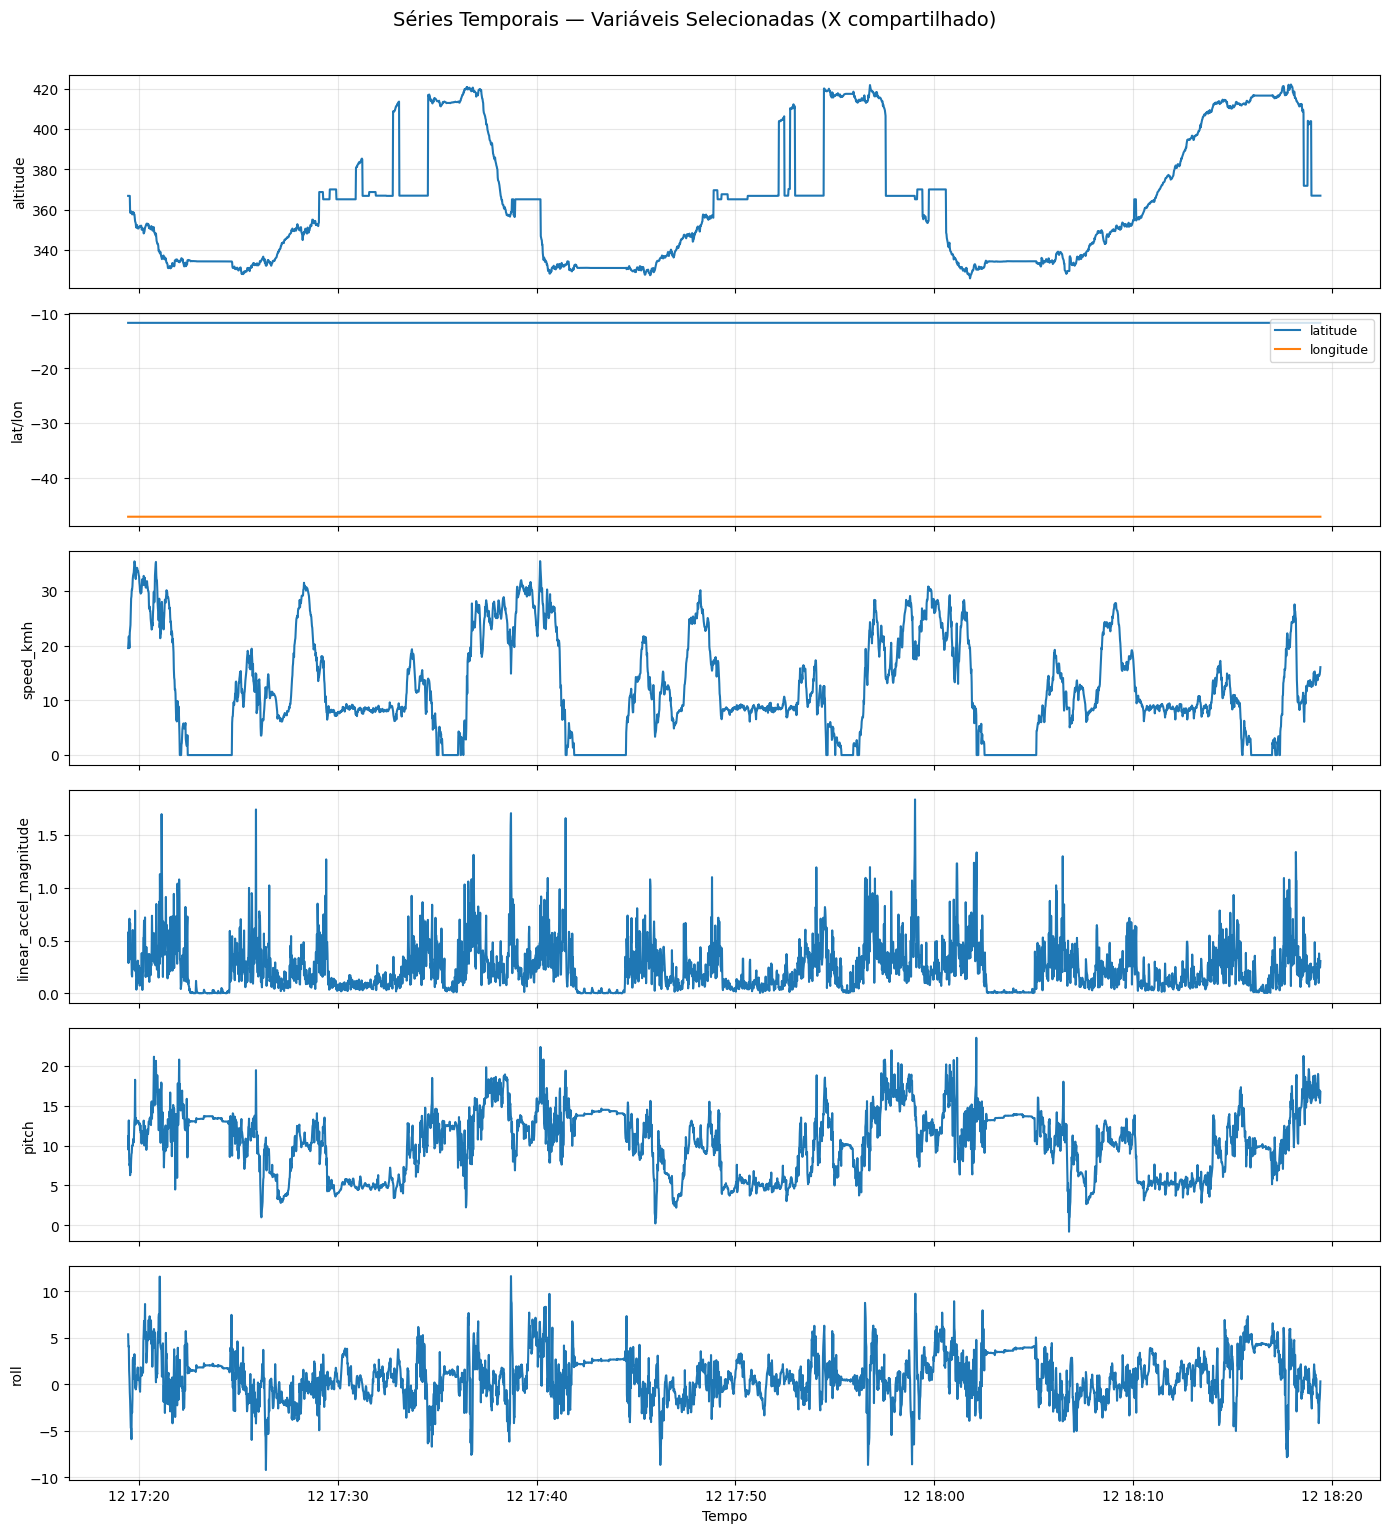

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

# ordem solicitada (lat/lon removido; latitude+longitude no mesmo subplot)
ORDER = [
    "altitude",
    ("latitude", "longitude"),  # mesmo gráfico
    "speed_kmh",
    "linear_accel_magnitude",
    "pitch",
    "roll",
]

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# =========================
# IDENTIFICA COLUNA DE TEMPO
# =========================
time_col = None
for c in df.columns:
    cl = c.lower()
    if cl in ("time", "timestamp", "datetime", "ts") or "time" in cl or "timestamp" in cl:
        time_col = c
        break

if time_col is None:
    raise ValueError("Coluna de tempo não encontrada (precisa conter 'time' ou 'timestamp' no nome).")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

# =========================
# COLETA COLUNAS NECESSÁRIAS
# =========================
needed = set()
for item in ORDER:
    if isinstance(item, tuple):
        needed.update(item)
    else:
        needed.add(item)

missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Colunas ausentes no CSV: {missing}")

df_sel = df[[time_col] + list(needed)].copy()

# remove colunas totalmente nulas
df_sel = df_sel.dropna(axis=1, how="all")

# remove colunas constantes
const_cols = [c for c in df_sel.columns if c != time_col and df_sel[c].nunique(dropna=True) <= 1]
df_sel = df_sel.drop(columns=const_cols)

# remove linhas com NaN nas colunas que permaneceram
cols_kept = [c for c in df_sel.columns if c != time_col]
df_sel = df_sel.dropna(subset=cols_kept, how="any")

# =========================
# PLOT (subplots empilhados, X compartilhado)
# =========================
fig, axes = plt.subplots(
    nrows=len(ORDER),
    ncols=1,
    figsize=(14, 2.6 * len(ORDER)),
    sharex=True
)

if len(ORDER) == 1:
    axes = [axes]

for ax, item in zip(axes, ORDER):
    if isinstance(item, tuple):
        # latitude e longitude no mesmo subplot
        for col in item:
            if col in df_sel.columns:
                ax.plot(df_sel[time_col], df_sel[col], label=col)
        ax.set_ylabel("lat/lon")
        ax.legend(loc="upper right", fontsize=9)
    else:
        if item not in df_sel.columns:
            # pode ter sido removida por ser constante/nula
            ax.text(0.01, 0.5, f"{item} removida (nula/constante)", transform=ax.transAxes, va="center")
            ax.set_ylabel(item)
        else:
            ax.plot(df_sel[time_col], df_sel[item])
            ax.set_ylabel(item)

    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Tempo")
plt.suptitle("Séries Temporais — Variáveis Selecionadas (X compartilhado)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


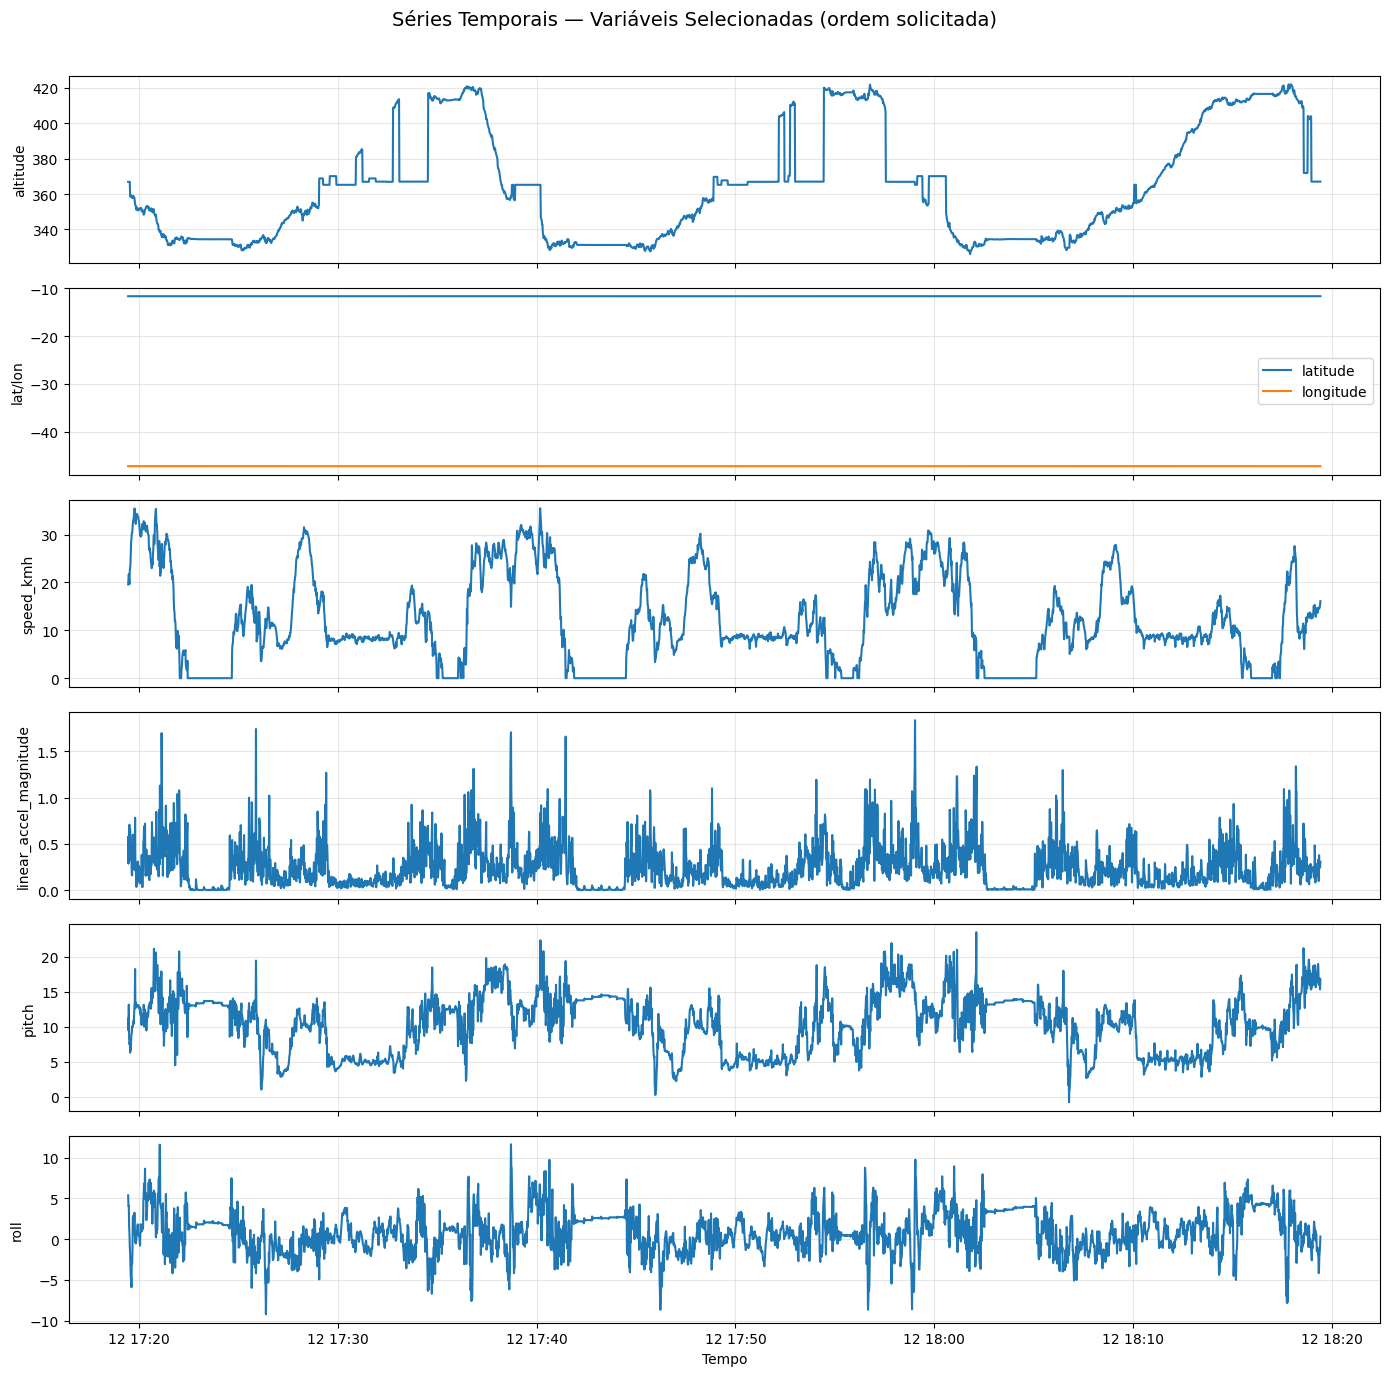

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"
TIME_COL_CANDIDATES = ["time", "timestamp", "datetime", "ts"]

# ordem solicitada
ALT_COL = "altitude"
LAT_COL = "latitude"
LON_COL = "longitude"
SPD_COL = "speed_kmh"
ACC_COL = "linear_accel_magnitude"
PITCH_COL = "pitch"
ROLL_COL = "roll"

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# identifica coluna de tempo
time_col = None
for c in df.columns:
    cl = c.lower()
    if cl in TIME_COL_CANDIDATES or "time" in cl or "timestamp" in cl:
        time_col = c
        break

if time_col is None:
    raise ValueError("Coluna de tempo não encontrada (esperado conter 'time' ou 'timestamp').")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

# =========================
# SELEÇÃO + LIMPEZA
# =========================
wanted_cols = [ALT_COL, LAT_COL, LON_COL, SPD_COL, ACC_COL, PITCH_COL, ROLL_COL]
missing = [c for c in wanted_cols if c not in df.columns]
if missing:
    raise ValueError(f"Colunas ausentes no CSV: {missing}")

df_sel = df[[time_col] + wanted_cols].copy()

# remove linhas com NaN (para manter todos os subplots alinhados)
df_sel = df_sel.dropna(axis=0, how="any")

# =========================
# PLOT (subplots com mesmo eixo X)
# =========================
# 1) altitude
# 2) latitude + longitude (no mesmo eixo)
# 3) speed_kmh
# 4) linear_accel_magnitude
# 5) pitch
# 6) roll
fig, axes = plt.subplots(
    nrows=6,
    ncols=1,
    figsize=(14, 14),
    sharex=True
)

# 1) altitude
axes[0].plot(df_sel[time_col], df_sel[ALT_COL])
axes[0].set_ylabel(ALT_COL)
axes[0].grid(True, alpha=0.3)

# 2) latitude e longitude no mesmo gráfico
axes[1].plot(df_sel[time_col], df_sel[LAT_COL], label=LAT_COL)
axes[1].plot(df_sel[time_col], df_sel[LON_COL], label=LON_COL)
axes[1].set_ylabel("lat/lon")
axes[1].legend(loc="best")
axes[1].grid(True, alpha=0.3)

# 3) speed_kmh
axes[2].plot(df_sel[time_col], df_sel[SPD_COL])
axes[2].set_ylabel(SPD_COL)
axes[2].grid(True, alpha=0.3)

# 4) linear_accel_magnitude
axes[3].plot(df_sel[time_col], df_sel[ACC_COL])
axes[3].set_ylabel(ACC_COL)
axes[3].grid(True, alpha=0.3)

# 5) pitch
axes[4].plot(df_sel[time_col], df_sel[PITCH_COL])
axes[4].set_ylabel(PITCH_COL)
axes[4].grid(True, alpha=0.3)

# 6) roll
axes[5].plot(df_sel[time_col], df_sel[ROLL_COL])
axes[5].set_ylabel(ROLL_COL)
axes[5].grid(True, alpha=0.3)

axes[-1].set_xlabel("Tempo")

plt.suptitle("Séries Temporais — Variáveis Selecionadas (ordem solicitada)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


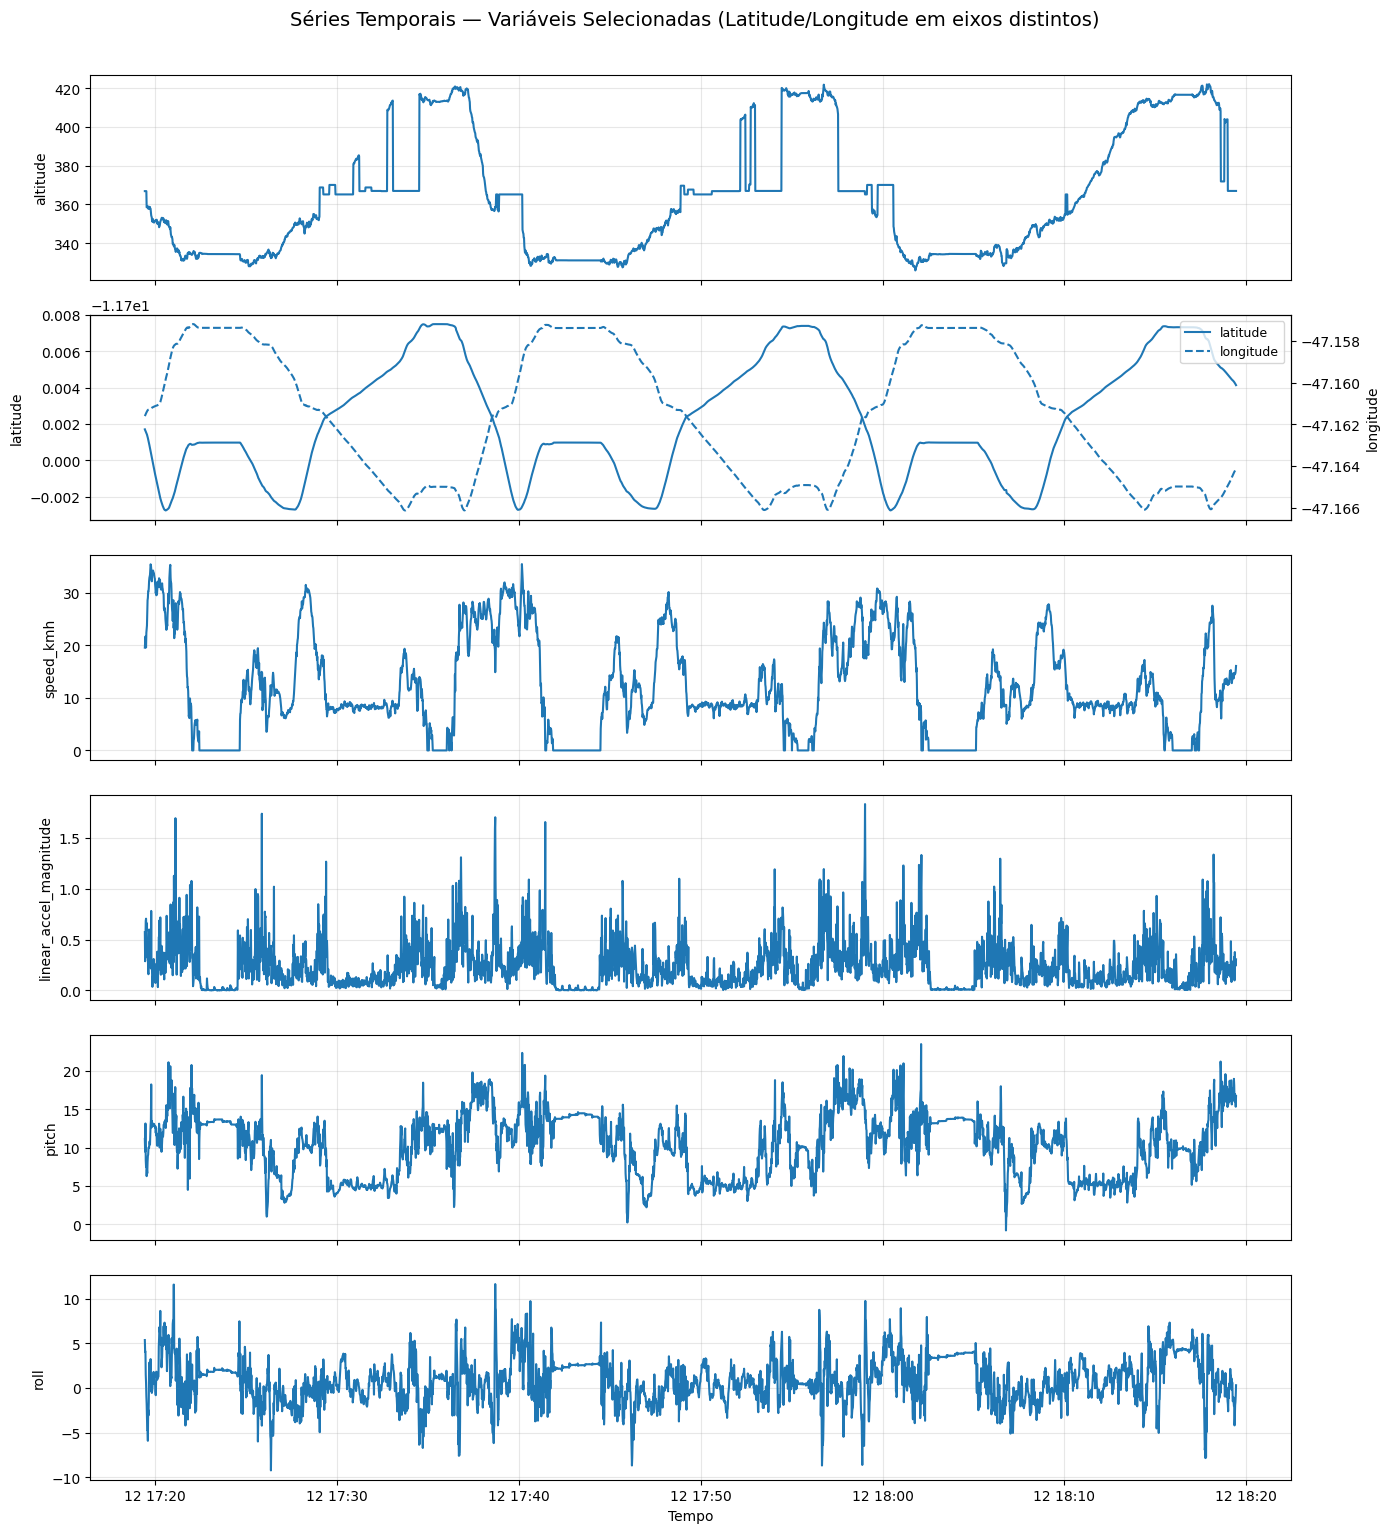

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

ORDER = [
    "altitude",
    ("latitude", "longitude"),  # mesmo gráfico, eixos Y diferentes
    "speed_kmh",
    "linear_accel_magnitude",
    "pitch",
    "roll",
]

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# =========================
# IDENTIFICA COLUNA DE TEMPO
# =========================
time_col = None
for c in df.columns:
    cl = c.lower()
    if cl in ("time", "timestamp", "datetime", "ts") or "time" in cl or "timestamp" in cl:
        time_col = c
        break

if time_col is None:
    raise ValueError("Coluna de tempo não encontrada.")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

# =========================
# COLETA COLUNAS NECESSÁRIAS
# =========================
needed = set()
for item in ORDER:
    if isinstance(item, tuple):
        needed.update(item)
    else:
        needed.add(item)

missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Colunas ausentes no CSV: {missing}")

df_sel = df[[time_col] + list(needed)].copy()

# remove colunas totalmente nulas
df_sel = df_sel.dropna(axis=1, how="all")

# remove colunas constantes
const_cols = [c for c in df_sel.columns if c != time_col and df_sel[c].nunique(dropna=True) <= 1]
df_sel = df_sel.drop(columns=const_cols)

# remove linhas com NaN
cols_kept = [c for c in df_sel.columns if c != time_col]
df_sel = df_sel.dropna(subset=cols_kept, how="any")

# =========================
# PLOT
# =========================
fig, axes = plt.subplots(
    nrows=len(ORDER),
    ncols=1,
    figsize=(14, 2.6 * len(ORDER)),
    sharex=True
)

if len(ORDER) == 1:
    axes = [axes]

for ax, item in zip(axes, ORDER):
    if isinstance(item, tuple):
        lat_col, lon_col = item

        ax.plot(df_sel[time_col], df_sel[lat_col], label="latitude")
        ax.set_ylabel("latitude")

        ax2 = ax.twinx()
        ax2.plot(df_sel[time_col], df_sel[lon_col], linestyle="--", label="longitude")
        ax2.set_ylabel("longitude")

        # legenda combinada
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=9)

    else:
        if item not in df_sel.columns:
            ax.text(
                0.01, 0.5,
                f"{item} removida (nula/constante)",
                transform=ax.transAxes,
                va="center"
            )
            ax.set_ylabel(item)
        else:
            ax.plot(df_sel[time_col], df_sel[item])
            ax.set_ylabel(item)

    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Tempo")
plt.suptitle("Séries Temporais — Variáveis Selecionadas (Latitude/Longitude em eixos distintos)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


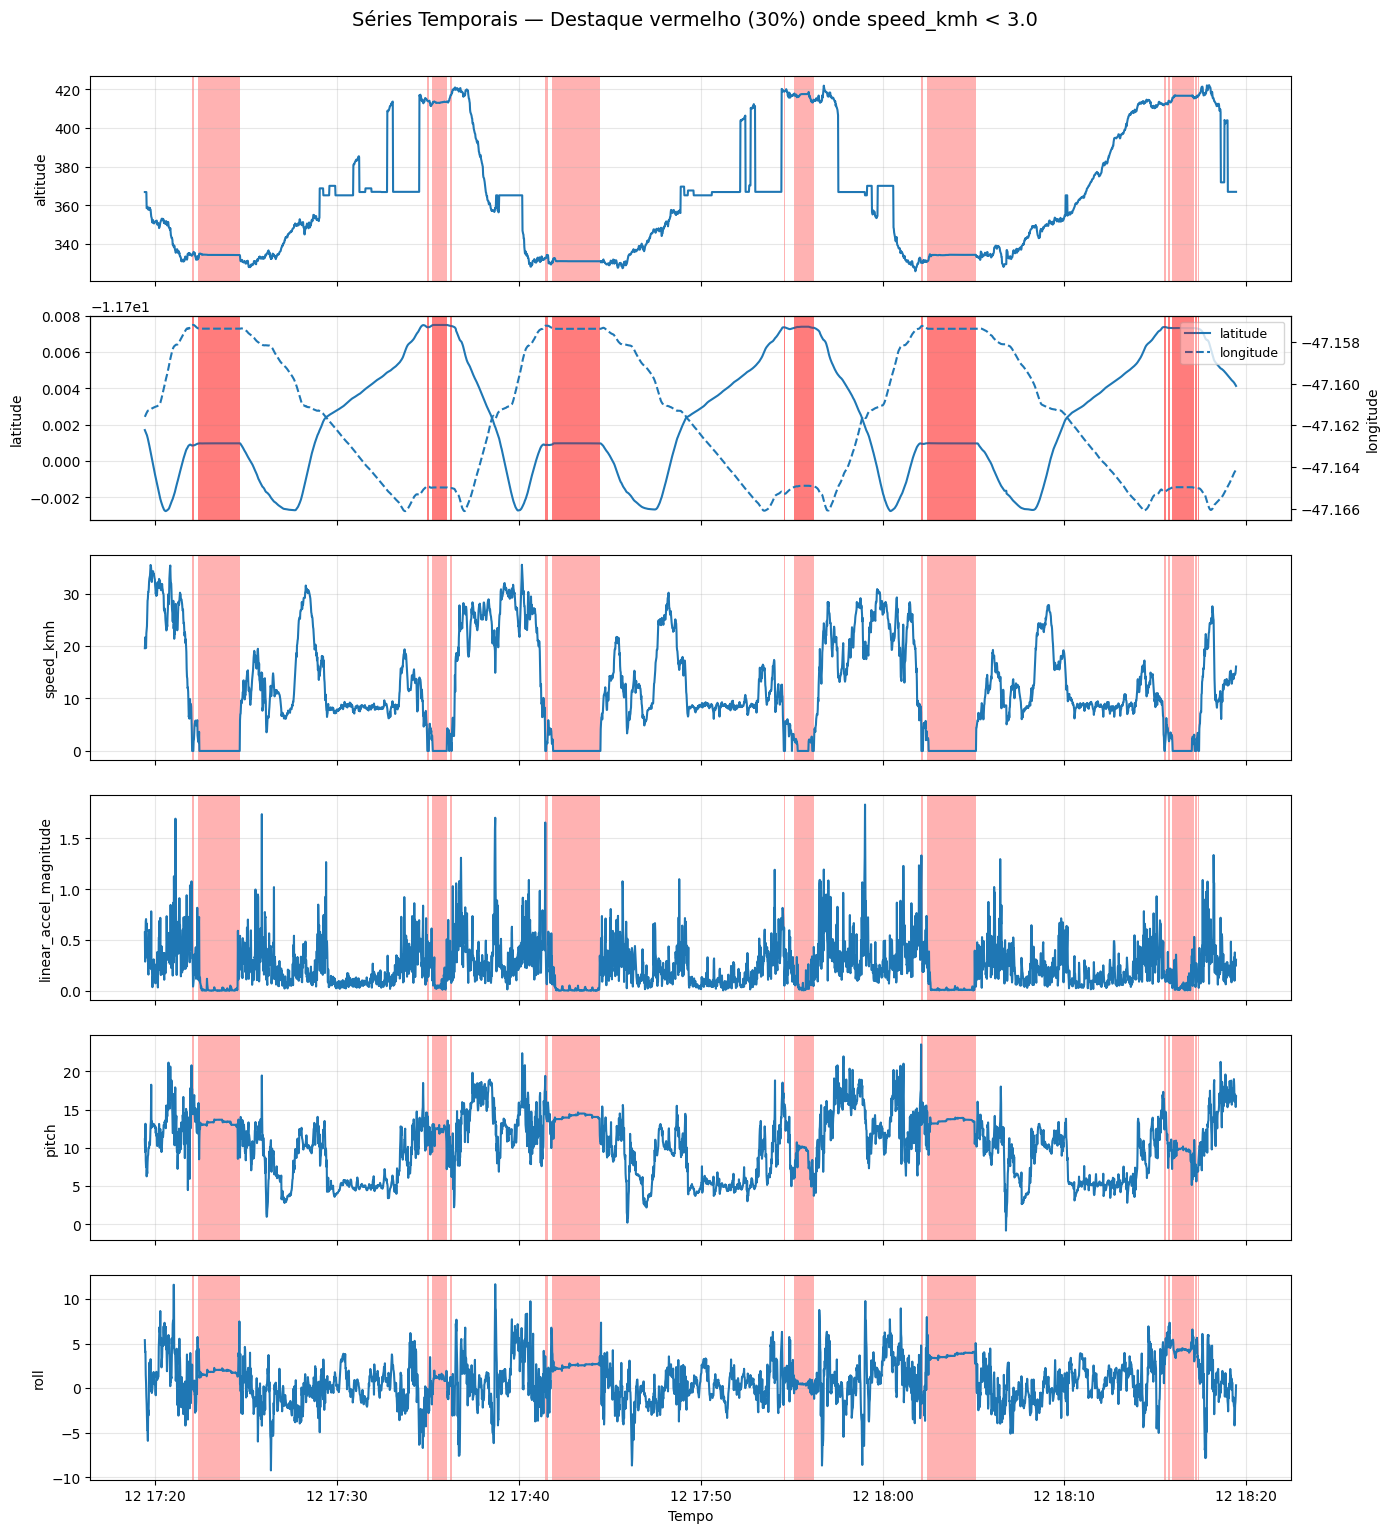

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"
SPEED_COL = "speed_kmh"
SPEED_THRESHOLD = 3.0

ORDER = [
    "altitude",
    ("latitude", "longitude"),  # mesmo gráfico, eixos Y diferentes
    "speed_kmh",
    "linear_accel_magnitude",
    "pitch",
    "roll",
]

# =========================
# HELPERS
# =========================
def find_intervals(time_series: pd.Series, mask: pd.Series):
    """
    Retorna lista de (t_start, t_end) para trechos contínuos onde mask==True.
    """
    m = mask.fillna(False).to_numpy(dtype=bool)
    if len(m) == 0:
        return []

    starts = np.where(m & ~np.r_[False, m[:-1]])[0]
    ends = np.where(m & ~np.r_[m[1:], False])[0]

    return [(time_series.iloc[s], time_series.iloc[e]) for s, e in zip(starts, ends)]

def shade_intervals(ax, intervals, color="red", alpha=0.30, zorder=0):
    for t0, t1 in intervals:
        ax.axvspan(
            t0,
            t1,
            facecolor=color,
            alpha=alpha,
            zorder=zorder
        )

# =========================
# LOAD
# =========================
df = pd.read_csv(CSV_PATH)

# =========================
# IDENTIFICA COLUNA DE TEMPO
# =========================
time_col = None
for c in df.columns:
    cl = c.lower()
    if cl in ("time", "timestamp", "datetime", "ts") or "time" in cl or "timestamp" in cl:
        time_col = c
        break

if time_col is None:
    raise ValueError("Coluna de tempo não encontrada.")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

# =========================
# SELEÇÃO E LIMPEZA
# =========================
needed = {SPEED_COL}
for item in ORDER:
    if isinstance(item, tuple):
        needed.update(item)
    else:
        needed.add(item)

missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Colunas ausentes no CSV: {missing}")

df_sel = df[[time_col] + list(needed)].copy()

df_sel = df_sel.dropna(axis=1, how="all")

const_cols = [
    c for c in df_sel.columns
    if c != time_col and df_sel[c].nunique(dropna=True) <= 1
]
df_sel = df_sel.drop(columns=const_cols)

df_sel = df_sel.dropna(subset=[c for c in df_sel.columns if c != time_col])

# =========================
# INTERVALOS speed < threshold
# =========================
intervals = find_intervals(
    df_sel[time_col],
    df_sel[SPEED_COL] < SPEED_THRESHOLD
)

# =========================
# PLOT
# =========================
fig, axes = plt.subplots(
    nrows=len(ORDER),
    ncols=1,
    figsize=(14, 2.6 * len(ORDER)),
    sharex=True
)

if len(ORDER) == 1:
    axes = [axes]

for ax, item in zip(axes, ORDER):
    # fundo vermelho (velocidade baixa)
    shade_intervals(ax, intervals, color="red", alpha=0.30, zorder=0)

    if isinstance(item, tuple):
        lat_col, lon_col = item

        ax.plot(df_sel[time_col], df_sel[lat_col], label="latitude")
        ax.set_ylabel("latitude")

        ax2 = ax.twinx()
        ax2.plot(df_sel[time_col], df_sel[lon_col], linestyle="--", label="longitude")
        ax2.set_ylabel("longitude")

        # garante o mesmo fundo no eixo direito
        shade_intervals(ax2, intervals, color="red", alpha=0.30, zorder=0)

        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=9)

    else:
        ax.plot(df_sel[time_col], df_sel[item])
        ax.set_ylabel(item)

    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Tempo")
plt.suptitle(
    f"Séries Temporais — Destaque vermelho (30%) onde {SPEED_COL} < {SPEED_THRESHOLD}",
    fontsize=14
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [13]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

ORDER = [
    "altitude",
    "latitude",
    "longitude",
    "speed_kmh",
    "linear_accel_magnitude",
    "pitch",
    "roll",
]

# -------------------------
# Load + time column detect
# -------------------------
df = pd.read_csv(CSV_PATH)

time_col = None
for c in df.columns:
    cl = c.lower()
    if cl in ("time", "timestamp", "datetime", "ts") or "time" in cl or "timestamp" in cl:
        time_col = c
        break

if time_col is None:
    raise ValueError("Coluna de tempo não encontrada (precisa conter 'time' ou 'timestamp' no nome).")

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

# mantém apenas colunas existentes + remove constantes/nulas
cols = [c for c in ORDER if c in df.columns]
df_sel = df[[time_col] + cols].copy()
df_sel = df_sel.dropna(axis=1, how="all")

# remove constantes
for c in cols[:]:
    if c in df_sel.columns and df_sel[c].nunique(dropna=True) <= 1:
        df_sel = df_sel.drop(columns=[c])
        cols.remove(c)

# remove linhas com NaN nas colunas restantes
df_sel = df_sel.dropna(subset=cols, how="any")

if len(cols) < 1:
    raise ValueError("Nenhuma variável válida após limpeza.")

# -------------------------
# Normalização para caber tudo no mesmo eixo
# (z-score: (x - mean) / std)
# -------------------------
norm = pd.DataFrame(index=df_sel.index)
for c in cols:
    s = df_sel[c].astype(float)
    std = s.std()
    if std == 0 or np.isnan(std):
        continue
    norm[c] = (s - s.mean()) / std

# -------------------------
# Plotly
# -------------------------
fig = go.Figure()

for c in cols:
    if c not in norm.columns:
        continue
    fig.add_trace(
        go.Scatter(
            x=df_sel[time_col],
            y=norm[c],
            mode="lines",
            name=c,
            customdata=np.stack([df_sel[c].values], axis=-1),
            hovertemplate=(
                "<b>%{fullData.name}</b><br>"
                "t=%{x}<br>"
                "valor real=%{customdata[0]:.6f}<br>"
                "z=%{y:.3f}<extra></extra>"
            ),
        )
    )

fig.update_layout(
    title="Telemetria — Todas as variáveis (normalizadas) no mesmo gráfico",
    xaxis=dict(
        title="Tempo",
        rangeslider=dict(visible=True),
        showspikes=True,
        spikemode="across",
        spikesnap="cursor",
        showline=True,
    ),
    yaxis=dict(
        title="Valor normalizado (z-score)",
        zeroline=True
    ),
    hovermode="x unified",
    legend=dict(title="Clique para ligar/desligar"),
    height=650,
)

fig.show()


In [22]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

from dash import dcc, html, Input, Output, State, ALL
from jupyter_dash import JupyterDash

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

VARS = [
    "altitude",
    "latitude",
    "longitude",
    "speed_kmh",
    "linear_accel_magnitude",
    "pitch",
    "roll",
]

def detect_time_col(df: pd.DataFrame) -> str:
    for c in df.columns:
        cl = c.lower()
        if cl in ("time", "timestamp", "datetime", "ts") or "time" in cl or "timestamp" in cl:
            return c
    raise ValueError("Coluna de tempo não encontrada (precisa conter 'time' ou 'timestamp' no nome).")

def build_figure(df: pd.DataFrame, time_col: str, enabled_vars, y_ranges):
    fig = go.Figure()

    fig.update_layout(
        title="Multi-eixos Y (um por variável) — X compartilhado",
        hovermode="x unified",
        xaxis=dict(
            title="Tempo",
            rangeslider=dict(visible=True),
            showspikes=True,
            spikemode="across",
            spikesnap="cursor",
        ),
        margin=dict(l=90, r=90, t=60, b=50),
        height=780,
        legend=dict(title="Variáveis (clique para ocultar/mostrar)"),
    )

    left_positions  = [0.00, 0.07, 0.14, 0.21, 0.28]
    right_positions = [1.00, 0.93, 0.86, 0.79, 0.72]
    li, ri = 0, 0

    axis_index = 1

    for v in enabled_vars:
        if v not in df.columns:
            continue

        axis_name = "y" if axis_index == 1 else f"y{axis_index}"

        if axis_index == 1:
            side = "left"
            position = None
        else:
            if axis_index % 2 == 0:
                side = "right"
                position = right_positions[ri] if ri < len(right_positions) else 1.0
                ri += 1
            else:
                side = "left"
                position = left_positions[li] if li < len(left_positions) else 0.0
                li += 1

        r = y_ranges.get(v, {})
        y_min = r.get("min", None)
        y_max = r.get("max", None)
        use_manual = (y_min is not None) or (y_max is not None)

        axis_layout = dict(
            title=v,
            overlaying="y" if axis_index != 1 else None,
            side=side,
            position=position,
            showgrid=(axis_index == 1),
            zeroline=False,
        )

        if use_manual:
            s = pd.to_numeric(df[v], errors="coerce")
            auto_min = float(np.nanmin(s))
            auto_max = float(np.nanmax(s))
            axis_layout["range"] = [
                auto_min if y_min is None else float(y_min),
                auto_max if y_max is None else float(y_max),
            ]

        fig.update_layout({f"{axis_name}axis": axis_layout})

        fig.add_trace(
            go.Scatter(
                x=df[time_col],
                y=df[v],
                name=v,
                mode="lines",
                yaxis=axis_name,
            )
        )

        axis_index += 1

    return fig

def range_row(v):
    return html.Div(
        style={
            "display": "grid",
            "gridTemplateColumns": "140px 1fr 1fr",
            "gap": "8px",
            "alignItems": "center",
            "marginBottom": "6px",
        },
        children=[
            html.Div(v, style={"fontWeight": "600"}),
            dcc.Input(id={"type": "ymin", "var": v}, type="number", placeholder="y min", debounce=True),
            dcc.Input(id={"type": "ymax", "var": v}, type="number", placeholder="y max", debounce=True),
        ],
    )

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(CSV_PATH)
time_col = detect_time_col(df)

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

available = []
for v in VARS:
    if v in df.columns:
        s = pd.to_numeric(df[v], errors="coerce")
        if s.dropna().nunique() > 1:
            available.append(v)

if not available:
    raise ValueError("Nenhuma variável válida encontrada (existente e não constante).")

# =========================
# APP
# =========================
app = JupyterDash(__name__)

app.layout = html.Div(
    style={"display": "grid", "gridTemplateColumns": "420px 1fr", "gap": "14px", "padding": "12px"},
    children=[
        html.Div(
            style={"border": "1px solid #ddd", "borderRadius": "8px", "padding": "12px"},
            children=[
                html.H3("Controles", style={"marginTop": 0}),
                html.Div("Ativar/Desativar variáveis:"),
                dcc.Checklist(
                    id="enabled-vars",
                    options=[{"label": v, "value": v} for v in available],
                    value=available,
                    style={"display": "grid", "gridTemplateColumns": "1fr", "gap": "4px", "marginTop": "8px"},
                ),
                html.Hr(),
                html.Div("Ajustar limites de cada eixo Y (deixe em branco para auto):"),
                html.Div([range_row(v) for v in available], style={"marginTop": "8px"}),
                html.Div(
                    style={"marginTop": "10px", "fontSize": "12px", "color": "#555"},
                    children="Dica: você também pode ocultar/mostrar curvas clicando na legenda do gráfico.",
                ),
            ],
        ),
        html.Div(children=[dcc.Graph(id="graph", config={"displayModeBar": True})]),
    ],
)

@app.callback(
    Output("graph", "figure"),
    Input("enabled-vars", "value"),
    Input({"type": "ymin", "var": ALL}, "value"),
    Input({"type": "ymax", "var": ALL}, "value"),
    State({"type": "ymin", "var": ALL}, "id"),
    prevent_initial_call=False,
)
def update(enabled_vars, ymin_vals, ymax_vals, ymin_ids):
    y_ranges = {}import pandas as pd
import numpy as np
import plotly.graph_objects as go

from dash import Dash, dcc, html, Input, Output, State, ALL

# =========================
# CONFIG
# =========================
CSV_PATH = r"D:\tracking\BackendTestes\telemetry_5horas_20251212_181926.csv"

VARS = [
    "altitude",
    "latitude",
    "longitude",
    "speed_kmh",
    "linear_accel_magnitude",
    "pitch",
    "roll",
]

def detect_time_col(df: pd.DataFrame) -> str:
    for c in df.columns:
        cl = c.lower()
        if cl in ("time", "timestamp", "datetime", "ts") or "time" in cl or "timestamp" in cl:
            return c
    raise ValueError("Coluna de tempo não encontrada (precisa conter 'time' ou 'timestamp' no nome).")

def build_figure(df: pd.DataFrame, time_col: str, enabled_vars, y_ranges):
    fig = go.Figure()

    fig.update_layout(
        title="Multi-eixos Y (um por variável) — X compartilhado",
        hovermode="x unified",
        xaxis=dict(
            title="Tempo",
            rangeslider=dict(visible=True),
            showspikes=True,
            spikemode="across",
            spikesnap="cursor",
        ),
        margin=dict(l=95, r=95, t=60, b=50),
        height=780,
        legend=dict(title="Variáveis (clique para ocultar/mostrar)"),
    )

    # posições para reduzir sobreposição de eixos
    left_positions  = [0.00, 0.07, 0.14, 0.21, 0.28, 0.35]
    right_positions = [1.00, 0.93, 0.86, 0.79, 0.72, 0.65]
    li, ri = 0, 0

    axis_index = 1

    for v in enabled_vars:
        if v not in df.columns:
            continue

        axis_name = "y" if axis_index == 1 else f"y{axis_index}"

        if axis_index == 1:
            side = "left"
            position = None
        else:
            if axis_index % 2 == 0:
                side = "right"
                position = right_positions[ri] if ri < len(right_positions) else 1.0
                ri += 1
            else:
                side = "left"
                position = left_positions[li] if li < len(left_positions) else 0.0
                li += 1

        r = y_ranges.get(v, {})
        y_min = r.get("min", None)
        y_max = r.get("max", None)
        use_manual = (y_min is not None) or (y_max is not None)

        axis_layout = dict(
            title=v,
            overlaying="y" if axis_index != 1 else None,
            side=side,
            position=position,
            showgrid=(axis_index == 1),
            zeroline=False,
        )

        if use_manual:
            s = pd.to_numeric(df[v], errors="coerce")
            auto_min = float(np.nanmin(s))
            auto_max = float(np.nanmax(s))
            axis_layout["range"] = [
                auto_min if y_min is None else float(y_min),
                auto_max if y_max is None else float(y_max),
            ]

        fig.update_layout({f"{axis_name}axis": axis_layout})

        fig.add_trace(
            go.Scatter(
                x=df[time_col],
                y=df[v],
                name=v,
                mode="lines",
                yaxis=axis_name,
            )
        )

        axis_index += 1

    return fig

def range_row(v):
    return html.Div(
        style={
            "display": "grid",
            "gridTemplateColumns": "140px 1fr 1fr",
            "gap": "8px",
            "alignItems": "center",
            "marginBottom": "6px",
        },
        children=[
            html.Div(v, style={"fontWeight": "600"}),
            dcc.Input(id={"type": "ymin", "var": v}, type="number", placeholder="y min", debounce=True),
            dcc.Input(id={"type": "ymax", "var": v}, type="number", placeholder="y max", debounce=True),
        ],
    )

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(CSV_PATH)
time_col = detect_time_col(df)

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col)

available = []
for v in VARS:
    if v in df.columns:
        s = pd.to_numeric(df[v], errors="coerce")
        if s.dropna().nunique() > 1:
            available.append(v)

if not available:
    raise ValueError("Nenhuma variável válida encontrada (existente e não constante).")

# =========================
# DASH APP (nativo)
# =========================
app = Dash(__name__)

app.layout = html.Div(
    style={"display": "grid", "gridTemplateColumns": "420px 1fr", "gap": "14px", "padding": "12px"},
    children=[
        html.Div(
            style={"border": "1px solid #ddd", "borderRadius": "8px", "padding": "12px"},
            children=[
                html.H3("Controles", style={"marginTop": 0}),
                html.Div("Ativar/Desativar variáveis:"),
                dcc.Checklist(
                    id="enabled-vars",
                    options=[{"label": v, "value": v} for v in available],
                    value=available,
                    style={"display": "grid", "gridTemplateColumns": "1fr", "gap": "4px", "marginTop": "8px"},
                ),
                html.Hr(),
                html.Div("Ajustar limites de cada eixo Y (deixe em branco para auto):"),
                html.Div([range_row(v) for v in available], style={"marginTop": "8px"}),
                html.Div(
                    style={"marginTop": "10px", "fontSize": "12px", "color": "#555"},
                    children="Dica: além do checklist, você pode ocultar/mostrar curvas clicando na legenda do gráfico.",
                ),
            ],
        ),
        html.Div(children=[dcc.Graph(id="graph", config={"displayModeBar": True})]),
    ],
)

@app.callback(
    Output("graph", "figure"),
    Input("enabled-vars", "value"),
    Input({"type": "ymin", "var": ALL}, "value"),
    Input({"type": "ymax", "var": ALL}, "value"),
    State({"type": "ymin", "var": ALL}, "id"),
    prevent_initial_call=False,
)
def update(enabled_vars, ymin_vals, ymax_vals, ymin_ids):
    y_ranges = {}
    for i, idobj in enumerate(ymin_ids):
        v = idobj["var"]
        y_ranges.setdefault(v, {})
        y_ranges[v]["min"] = ymin_vals[i]
        y_ranges[v]["max"] = ymax_vals[i]
    return build_figure(df, time_col, enabled_vars, y_ranges)

# =========================
# RUN (Jupyter)
# =========================
# External: abre link no output da célula
app.run(jupyter_mode="external", debug=False, port=8050)
# Alternativas:
# app.run(jupyter_mode="inline", debug=False, port=8050)
# app.run(jupyter_mode="tab", debug=False, port=8050)

    for i, idobj in enumerate(ymin_ids):
        v = idobj["var"]
        y_ranges.setdefault(v, {})
        y_ranges[v]["min"] = ymin_vals[i]
        y_ranges[v]["max"] = ymax_vals[i]

    return build_figure(df, time_col, enabled_vars, y_ranges)


SyntaxError: invalid syntax (2703977198.py, line 188)